## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    g = a + b + c + d +np.random.normal(mean,var, SIZE)
    e = g + np.random.normal(mean, var, SIZE)
    f = g + np.random.normal(mean, var, SIZE)
    
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =300
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/f' + str(i))

print(models, model_names)


df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 2000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/f0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 182us/step - loss: 0.4559 - mean_squared_error: 0.4559 - val_loss: 0.3636 - val_mean_squared_error: 0.3636

Epoch 00001: val_loss improved from inf to 0.36364, saving model to temp/f0
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3597 - val_mean_squared_error: 0.3597

Epoch 00002: val_loss improved from 0.36364 to 0.35966, saving model to temp/f0
Epoch 3/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3620 - mean_squared_error: 0.3620 - val_loss: 0.3604 - val_mean_squared_error: 0.3604

Epoch 00003: val_loss did not improve from 0.35966
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.3547 - val_mean_squared_error: 0.3547

Epoch 00004: val_loss improved from 0.35966 to 0.35468, sav

20000/20000 [==============================] - 3s 131us/step - loss: 0.3643 - mean_squared_error: 0.3643 - val_loss: 0.3655 - val_mean_squared_error: 0.3655

Epoch 00002: val_loss improved from 0.36692 to 0.36547, saving model to temp/f3
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3635 - val_mean_squared_error: 0.3635

Epoch 00003: val_loss improved from 0.36547 to 0.36352, saving model to temp/f3
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3567 - val_mean_squared_error: 0.3567

Epoch 00004: val_loss improved from 0.36352 to 0.35671, saving model to temp/f3
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3551 - val_mean_squared_error: 0.3551

Epoch 00005: val_loss improved from 0.35671 to 0.35509, saving model to temp/f3
Epoch 6/20
2000

20000/20000 [==============================] - 3s 132us/step - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3595 - val_mean_squared_error: 0.3595

Epoch 00004: val_loss did not improve from 0.35840
Epoch 00004: early stopping
temp/f9
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 0.4500 - mean_squared_error: 0.4500 - val_loss: 0.3646 - val_mean_squared_error: 0.3646

Epoch 00001: val_loss improved from inf to 0.36455, saving model to temp/f9
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3651 - mean_squared_error: 0.3651 - val_loss: 0.3615 - val_mean_squared_error: 0.3615

Epoch 00002: val_loss improved from 0.36455 to 0.36147, saving model to temp/f9
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3623 - mean_squared_error: 0.3623 - val_loss: 0.3743 - val_mean_squared_error: 0.3743

Epoch 00003: val_loss did not improve from

20000/20000 [==============================] - 3s 131us/step - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3521 - val_mean_squared_error: 0.3521

Epoch 00005: val_loss improved from 0.35644 to 0.35211, saving model to temp/f14
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3575 - mean_squared_error: 0.3575 - val_loss: 0.3633 - val_mean_squared_error: 0.3633

Epoch 00006: val_loss did not improve from 0.35211
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3568 - val_mean_squared_error: 0.3568

Epoch 00007: val_loss did not improve from 0.35211
Epoch 00007: early stopping
temp/f15
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.4596 - mean_squared_error: 0.4596 - val_loss: 0.3636 - val_mean_squared_error: 0.3636

Epoch 00001: val_loss improved from inf to 0.36361, saving model 

20000/20000 [==============================] - 3s 132us/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3534 - val_mean_squared_error: 0.3534

Epoch 00005: val_loss improved from 0.35431 to 0.35344, saving model to temp/f19
Epoch 6/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.3574 - mean_squared_error: 0.3574 - val_loss: 0.3569 - val_mean_squared_error: 0.3569

Epoch 00006: val_loss did not improve from 0.35344
Epoch 7/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3556 - mean_squared_error: 0.3556 - val_loss: 0.3531 - val_mean_squared_error: 0.3531

Epoch 00007: val_loss improved from 0.35344 to 0.35314, saving model to temp/f19
Epoch 8/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3556 - mean_squared_error: 0.3556 - val_loss: 0.3594 - val_mean_squared_error: 0.3594

Epoch 00008: val_loss did not improve from 0.35314
Epoch 9/20
20000/20000 [==============================] - 3s 130us/step


Epoch 00013: val_loss did not improve from 0.35208
Epoch 14/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3540 - mean_squared_error: 0.3540 - val_loss: 0.3534 - val_mean_squared_error: 0.3534

Epoch 00014: val_loss did not improve from 0.35208
Epoch 00014: early stopping
temp/f23
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.4471 - mean_squared_error: 0.4471 - val_loss: 0.3663 - val_mean_squared_error: 0.3663

Epoch 00001: val_loss improved from inf to 0.36626, saving model to temp/f23
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3643 - val_mean_squared_error: 0.3643

Epoch 00002: val_loss improved from 0.36626 to 0.36434, saving model to temp/f23
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3692 - val_mea


Epoch 00005: val_loss did not improve from 0.35612
Epoch 00005: early stopping
temp/f28
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.3635 - val_mean_squared_error: 0.3635

Epoch 00001: val_loss improved from inf to 0.36355, saving model to temp/f28
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3586 - val_mean_squared_error: 0.3586

Epoch 00002: val_loss improved from 0.36355 to 0.35860, saving model to temp/f28
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3614 - mean_squared_error: 0.3614 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00003: val_loss improved from 0.35860 to 0.35603, saving model to temp/f28
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3603 - mean_squared_error: 0.3603

20000/20000 [==============================] - 3s 132us/step - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3677 - val_mean_squared_error: 0.3677

Epoch 00002: val_loss did not improve from 0.36196
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3583 - val_mean_squared_error: 0.3583

Epoch 00003: val_loss improved from 0.36196 to 0.35834, saving model to temp/f33
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3550 - val_mean_squared_error: 0.3550

Epoch 00004: val_loss improved from 0.35834 to 0.35503, saving model to temp/f33
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3618 - val_mean_squared_error: 0.3618

Epoch 00005: val_loss did not improve from 0.35503
Epoch 6/20
20000/20000 [==============================] - 3s 132us/step

20000/20000 [==============================] - 3s 131us/step - loss: 0.3567 - mean_squared_error: 0.3567 - val_loss: 0.3547 - val_mean_squared_error: 0.3547

Epoch 00008: val_loss did not improve from 0.35260
Epoch 9/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3553 - val_mean_squared_error: 0.3553

Epoch 00009: val_loss did not improve from 0.35260
Epoch 00009: early stopping
temp/f38
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 0.4572 - mean_squared_error: 0.4572 - val_loss: 0.3644 - val_mean_squared_error: 0.3644

Epoch 00001: val_loss improved from inf to 0.36439, saving model to temp/f38
Epoch 2/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3644 - mean_squared_error: 0.3644 - val_loss: 0.3655 - val_mean_squared_error: 0.3655

Epoch 00002: val_loss did not improve from 0.36439
Epoch 3/20
20000/2


Epoch 00003: val_loss did not improve from 0.35912
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3557 - val_mean_squared_error: 0.3557

Epoch 00004: val_loss improved from 0.35912 to 0.35566, saving model to temp/f43
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3531 - val_mean_squared_error: 0.3531

Epoch 00005: val_loss improved from 0.35566 to 0.35314, saving model to temp/f43
Epoch 6/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3576 - val_mean_squared_error: 0.3576

Epoch 00006: val_loss did not improve from 0.35314
Epoch 7/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3623 - val_mean_squared_error: 0.3623

Epoch 00007: val_loss did not improve from 0.35314
Epoch 00

20000/20000 [==============================] - 3s 135us/step - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3627 - val_mean_squared_error: 0.3627

Epoch 00004: val_loss did not improve from 0.35829
Epoch 00004: early stopping
temp/f50
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 0.4691 - mean_squared_error: 0.4691 - val_loss: 0.3633 - val_mean_squared_error: 0.3633

Epoch 00001: val_loss improved from inf to 0.36326, saving model to temp/f50
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3668 - mean_squared_error: 0.3668 - val_loss: 0.3583 - val_mean_squared_error: 0.3583

Epoch 00002: val_loss improved from 0.36326 to 0.35831, saving model to temp/f50
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3572 - val_mean_squared_error: 0.3572

Epoch 00003: val_loss improved from 0.3

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.4618 - mean_squared_error: 0.4618 - val_loss: 0.3681 - val_mean_squared_error: 0.3681

Epoch 00001: val_loss improved from inf to 0.36807, saving model to temp/f54
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3634 - val_mean_squared_error: 0.3634

Epoch 00002: val_loss improved from 0.36807 to 0.36344, saving model to temp/f54
Epoch 3/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3569 - val_mean_squared_error: 0.3569

Epoch 00003: val_loss improved from 0.36344 to 0.35690, saving model to temp/f54
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3586 - mean_squared_error: 0.3586 - val_loss: 0.3555 - val_mean_squared_error: 0.3555

Epoch 00004: val_loss improved from

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.4529 - mean_squared_error: 0.4529 - val_loss: 0.3658 - val_mean_squared_error: 0.3658

Epoch 00001: val_loss improved from inf to 0.36577, saving model to temp/f59
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3638 - mean_squared_error: 0.3638 - val_loss: 0.3598 - val_mean_squared_error: 0.3598

Epoch 00002: val_loss improved from 0.36577 to 0.35975, saving model to temp/f59
Epoch 3/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3567 - val_mean_squared_error: 0.3567

Epoch 00003: val_loss improved from 0.35975 to 0.35669, saving model to temp/f59
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3581 - val_mean_squared_error: 0.3581

Epoch 00004: val_loss did not impro

20000/20000 [==============================] - 3s 132us/step - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3594 - val_mean_squared_error: 0.3594

Epoch 00006: val_loss did not improve from 0.35554
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.3554 - val_mean_squared_error: 0.3554

Epoch 00007: val_loss improved from 0.35554 to 0.35538, saving model to temp/f62
Epoch 8/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.3649 - val_mean_squared_error: 0.3649

Epoch 00008: val_loss did not improve from 0.35538
Epoch 9/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3583 - mean_squared_error: 0.3583 - val_loss: 0.3595 - val_mean_squared_error: 0.3595

Epoch 00009: val_loss did not improve from 0.35538
Epoch 00009: early stopping
temp/f63
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
200

20000/20000 [==============================] - 3s 132us/step - loss: 0.3654 - mean_squared_error: 0.3654 - val_loss: 0.3650 - val_mean_squared_error: 0.3650

Epoch 00003: val_loss did not improve from 0.35855
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3580 - val_mean_squared_error: 0.3580

Epoch 00004: val_loss improved from 0.35855 to 0.35804, saving model to temp/f66
Epoch 5/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 0.3540 - val_mean_squared_error: 0.3540

Epoch 00005: val_loss improved from 0.35804 to 0.35401, saving model to temp/f66
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3586 - val_mean_squared_error: 0.3586

Epoch 00006: val_loss did not improve from 0.35401
Epoch 7/20
20000/20000 [==============================] - 3s 132us/step

20000/20000 [==============================] - 3s 131us/step - loss: 0.3620 - mean_squared_error: 0.3620 - val_loss: 0.3573 - val_mean_squared_error: 0.3573

Epoch 00003: val_loss improved from 0.36148 to 0.35731, saving model to temp/f71
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3541 - val_mean_squared_error: 0.3541

Epoch 00004: val_loss improved from 0.35731 to 0.35414, saving model to temp/f71
Epoch 5/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3554 - val_mean_squared_error: 0.3554

Epoch 00005: val_loss did not improve from 0.35414
Epoch 6/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3538 - val_mean_squared_error: 0.3538

Epoch 00006: val_loss improved from 0.35414 to 0.35380, saving model to temp/f71
Epoch 7/20
20000/20000 [=================

20000/20000 [==============================] - 3s 132us/step - loss: 0.3576 - mean_squared_error: 0.3576 - val_loss: 0.3528 - val_mean_squared_error: 0.3528

Epoch 00005: val_loss improved from 0.35605 to 0.35282, saving model to temp/f75
Epoch 6/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3554 - val_mean_squared_error: 0.3554

Epoch 00006: val_loss did not improve from 0.35282
Epoch 7/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.3608 - val_mean_squared_error: 0.3608

Epoch 00007: val_loss did not improve from 0.35282
Epoch 00007: early stopping
temp/f76
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.4525 - mean_squared_error: 0.4525 - val_loss: 0.3626 - val_mean_squared_error: 0.3626

Epoch 00001: val_loss improved from inf to 0.36261, saving model 

20000/20000 [==============================] - 3s 131us/step - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3591 - val_mean_squared_error: 0.3591

Epoch 00003: val_loss did not improve from 0.35781
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3595 - val_mean_squared_error: 0.3595

Epoch 00004: val_loss did not improve from 0.35781
Epoch 00004: early stopping
temp/f81
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 0.4559 - mean_squared_error: 0.4559 - val_loss: 0.3654 - val_mean_squared_error: 0.3654

Epoch 00001: val_loss improved from inf to 0.36541, saving model to temp/f81
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3679 - val_mean_squared_error: 0.3679

Epoch 00002: val_loss did not improve from 0.36541
Epoch 3/20
20000/2

20000/20000 [==============================] - 3s 131us/step - loss: 0.3571 - mean_squared_error: 0.3571 - val_loss: 0.3527 - val_mean_squared_error: 0.3527

Epoch 00006: val_loss did not improve from 0.35249
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00007: val_loss did not improve from 0.35249
Epoch 00007: early stopping
temp/f86
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.4597 - mean_squared_error: 0.4597 - val_loss: 0.3662 - val_mean_squared_error: 0.3662

Epoch 00001: val_loss improved from inf to 0.36622, saving model to temp/f86
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.3673 - mean_squared_error: 0.3673 - val_loss: 0.3700 - val_mean_squared_error: 0.3700

Epoch 00002: val_loss did not improve from 0.36622
Epoch 3/20
20000/2

20000/20000 [==============================] - 3s 147us/step - loss: 0.4555 - mean_squared_error: 0.4555 - val_loss: 0.3670 - val_mean_squared_error: 0.3670

Epoch 00001: val_loss improved from inf to 0.36697, saving model to temp/f90
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.3640 - val_mean_squared_error: 0.3640

Epoch 00002: val_loss improved from 0.36697 to 0.36401, saving model to temp/f90
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3629 - mean_squared_error: 0.3629 - val_loss: 0.3611 - val_mean_squared_error: 0.3611

Epoch 00003: val_loss improved from 0.36401 to 0.36112, saving model to temp/f90
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3599 - val_mean_squared_error: 0.3599

Epoch 00004: val_loss improved from 0.36112 to 0.35993, saving model to temp/f90
Epoch 5/20
2000

20000/20000 [==============================] - 3s 134us/step - loss: 0.3583 - mean_squared_error: 0.3583 - val_loss: 0.3584 - val_mean_squared_error: 0.3584

Epoch 00006: val_loss did not improve from 0.35404
Epoch 7/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3566 - val_mean_squared_error: 0.3566

Epoch 00007: val_loss did not improve from 0.35404
Epoch 00007: early stopping
temp/f94
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 0.4545 - mean_squared_error: 0.4545 - val_loss: 0.3691 - val_mean_squared_error: 0.3691

Epoch 00001: val_loss improved from inf to 0.36908, saving model to temp/f94
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3663 - mean_squared_error: 0.3663 - val_loss: 0.3594 - val_mean_squared_error: 0.3594

Epoch 00002: val_loss improved from 0.36908 to 0.35941, saving model 

20000/20000 [==============================] - 3s 132us/step - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3569 - val_mean_squared_error: 0.3569

Epoch 00002: val_loss improved from 0.37130 to 0.35691, saving model to temp/f97
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3567 - val_mean_squared_error: 0.3567

Epoch 00003: val_loss improved from 0.35691 to 0.35668, saving model to temp/f97
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3647 - val_mean_squared_error: 0.3647

Epoch 00004: val_loss did not improve from 0.35668
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3545 - val_mean_squared_error: 0.3545

Epoch 00005: val_loss improved from 0.35668 to 0.35447, saving model to temp/f97
Epoch 6/20
20000/20000 [=================


Epoch 00005: val_loss did not improve from 0.35796
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3540 - val_mean_squared_error: 0.3540

Epoch 00006: val_loss improved from 0.35796 to 0.35397, saving model to temp/f103
Epoch 7/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3576 - mean_squared_error: 0.3576 - val_loss: 0.3591 - val_mean_squared_error: 0.3591

Epoch 00007: val_loss did not improve from 0.35397
Epoch 8/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3544 - mean_squared_error: 0.3544 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00008: val_loss did not improve from 0.35397
Epoch 00008: early stopping
temp/f104
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.4578 - mean_squared_error: 0.4578 - val_loss: 0.3662 - val_mean_squared_error: 0.3662



20000/20000 [==============================] - 3s 130us/step - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3591 - val_mean_squared_error: 0.3591

Epoch 00005: val_loss did not improve from 0.35766
Epoch 6/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.3529 - val_mean_squared_error: 0.3529

Epoch 00006: val_loss improved from 0.35766 to 0.35288, saving model to temp/f108
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3576 - mean_squared_error: 0.3576 - val_loss: 0.3539 - val_mean_squared_error: 0.3539

Epoch 00007: val_loss did not improve from 0.35288
Epoch 8/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3559 - mean_squared_error: 0.3559 - val_loss: 0.3565 - val_mean_squared_error: 0.3565

Epoch 00008: val_loss did not improve from 0.35288
Epoch 00008: early stopping
temp/f109
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2

20000/20000 [==============================] - 3s 134us/step - loss: 0.3667 - mean_squared_error: 0.3667 - val_loss: 0.3638 - val_mean_squared_error: 0.3638

Epoch 00002: val_loss did not improve from 0.36360
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3651 - mean_squared_error: 0.3651 - val_loss: 0.3592 - val_mean_squared_error: 0.3592

Epoch 00003: val_loss improved from 0.36360 to 0.35924, saving model to temp/f113
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.3579 - mean_squared_error: 0.3579 - val_loss: 0.3592 - val_mean_squared_error: 0.3592

Epoch 00004: val_loss improved from 0.35924 to 0.35916, saving model to temp/f113
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3688 - val_mean_squared_error: 0.3688

Epoch 00005: val_loss did not improve from 0.35916
Epoch 00005: early stopping
temp/f114
Train on 20000 samples, validat

20000/20000 [==============================] - 3s 136us/step - loss: 0.3642 - mean_squared_error: 0.3642 - val_loss: 0.3586 - val_mean_squared_error: 0.3586

Epoch 00003: val_loss improved from 0.36133 to 0.35856, saving model to temp/f118
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3581 - val_mean_squared_error: 0.3581

Epoch 00004: val_loss improved from 0.35856 to 0.35806, saving model to temp/f118
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3592 - val_mean_squared_error: 0.3592

Epoch 00005: val_loss did not improve from 0.35806
Epoch 6/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3579 - val_mean_squared_error: 0.3579

Epoch 00006: val_loss improved from 0.35806 to 0.35791, saving model to temp/f118
Epoch 7/20
20000/20000 [==============

20000/20000 [==============================] - 3s 139us/step - loss: 0.3647 - mean_squared_error: 0.3647 - val_loss: 0.3596 - val_mean_squared_error: 0.3596

Epoch 00002: val_loss improved from 0.36711 to 0.35961, saving model to temp/f122
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3719 - val_mean_squared_error: 0.3719

Epoch 00003: val_loss did not improve from 0.35961
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3552 - val_mean_squared_error: 0.3552

Epoch 00004: val_loss improved from 0.35961 to 0.35524, saving model to temp/f122
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3570 - val_mean_squared_error: 0.3570

Epoch 00005: val_loss did not improve from 0.35524
Epoch 6/20
20000/20000 [==============================] - 3s 140us/st

20000/20000 [==============================] - 3s 139us/step - loss: 0.3567 - mean_squared_error: 0.3567 - val_loss: 0.3543 - val_mean_squared_error: 0.3543

Epoch 00009: val_loss did not improve from 0.35330
Epoch 10/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3563 - mean_squared_error: 0.3563 - val_loss: 0.3587 - val_mean_squared_error: 0.3587

Epoch 00010: val_loss did not improve from 0.35330
Epoch 00010: early stopping
temp/f126
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.4590 - mean_squared_error: 0.4590 - val_loss: 0.3706 - val_mean_squared_error: 0.3706

Epoch 00001: val_loss improved from inf to 0.37056, saving model to temp/f126
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.3604 - val_mean_squared_error: 0.3604

Epoch 00002: val_loss improved from 0.37056 to 0.36036, saving mod

20000/20000 [==============================] - 3s 139us/step - loss: 0.3563 - mean_squared_error: 0.3563 - val_loss: 0.3533 - val_mean_squared_error: 0.3533

Epoch 00008: val_loss improved from 0.35572 to 0.35329, saving model to temp/f129
Epoch 9/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.3515 - val_mean_squared_error: 0.3515

Epoch 00009: val_loss improved from 0.35329 to 0.35146, saving model to temp/f129
Epoch 10/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3579 - mean_squared_error: 0.3579 - val_loss: 0.3601 - val_mean_squared_error: 0.3601

Epoch 00010: val_loss did not improve from 0.35146
Epoch 11/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.3525 - val_mean_squared_error: 0.3525

Epoch 00011: val_loss did not improve from 0.35146
Epoch 00011: early stopping
temp/f130
Train on 20000 samples, valid

20000/20000 [==============================] - 3s 140us/step - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 0.3536 - val_mean_squared_error: 0.3536

Epoch 00008: val_loss improved from 0.35546 to 0.35357, saving model to temp/f133
Epoch 9/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3659 - val_mean_squared_error: 0.3659

Epoch 00009: val_loss did not improve from 0.35357
Epoch 10/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3547 - mean_squared_error: 0.3547 - val_loss: 0.3516 - val_mean_squared_error: 0.3516

Epoch 00010: val_loss improved from 0.35357 to 0.35162, saving model to temp/f133
Epoch 11/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.3494 - val_mean_squared_error: 0.3494

Epoch 00011: val_loss improved from 0.35162 to 0.34944, saving model to temp/f133
Epoch 12/20
20000/20000 [===========


Epoch 00002: val_loss improved from 0.36550 to 0.36349, saving model to temp/f138
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3539 - val_mean_squared_error: 0.3539

Epoch 00003: val_loss improved from 0.36349 to 0.35386, saving model to temp/f138
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3559 - val_mean_squared_error: 0.3559

Epoch 00004: val_loss did not improve from 0.35386
Epoch 5/20
20000/20000 [==============================] - 3s 142us/step - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.3534 - val_mean_squared_error: 0.3534

Epoch 00005: val_loss improved from 0.35386 to 0.35336, saving model to temp/f138
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3564 - mean_squared_error: 0.3564 - val_loss: 0.3541 - val_mean_squared_error: 0.3541

Epoch 00006: val_loss did 

20000/20000 [==============================] - 3s 140us/step - loss: 0.3559 - mean_squared_error: 0.3559 - val_loss: 0.3502 - val_mean_squared_error: 0.3502

Epoch 00010: val_loss improved from 0.35271 to 0.35016, saving model to temp/f141
Epoch 11/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3548 - mean_squared_error: 0.3548 - val_loss: 0.3586 - val_mean_squared_error: 0.3586

Epoch 00011: val_loss did not improve from 0.35016
Epoch 12/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.3538 - val_mean_squared_error: 0.3538

Epoch 00012: val_loss did not improve from 0.35016
Epoch 00012: early stopping
temp/f142
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.4459 - mean_squared_error: 0.4459 - val_loss: 0.3638 - val_mean_squared_error: 0.3638

Epoch 00001: val_loss improved from inf to 0.36375, saving mo


Epoch 00010: val_loss improved from 0.35233 to 0.35174, saving model to temp/f146
Epoch 11/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3539 - mean_squared_error: 0.3539 - val_loss: 0.3549 - val_mean_squared_error: 0.3549

Epoch 00011: val_loss did not improve from 0.35174
Epoch 12/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3545 - mean_squared_error: 0.3545 - val_loss: 0.3571 - val_mean_squared_error: 0.3571

Epoch 00012: val_loss did not improve from 0.35174
Epoch 00012: early stopping
temp/f147
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4653 - mean_squared_error: 0.4653 - val_loss: 0.3639 - val_mean_squared_error: 0.3639

Epoch 00001: val_loss improved from inf to 0.36387, saving model to temp/f147
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.3614 - val

20000/20000 [==============================] - 3s 139us/step - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00006: val_loss did not improve from 0.35495
Epoch 7/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.3553 - mean_squared_error: 0.3553 - val_loss: 0.3508 - val_mean_squared_error: 0.3508

Epoch 00007: val_loss improved from 0.35495 to 0.35076, saving model to temp/f151
Epoch 8/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3564 - mean_squared_error: 0.3564 - val_loss: 0.3522 - val_mean_squared_error: 0.3522

Epoch 00008: val_loss did not improve from 0.35076
Epoch 9/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.3535 - mean_squared_error: 0.3535 - val_loss: 0.3519 - val_mean_squared_error: 0.3519

Epoch 00009: val_loss did not improve from 0.35076
Epoch 00009: early stopping
temp/f152
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2


Epoch 00003: val_loss did not improve from 0.36001
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3577 - val_mean_squared_error: 0.3577

Epoch 00004: val_loss improved from 0.36001 to 0.35766, saving model to temp/f156
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3533 - val_mean_squared_error: 0.3533

Epoch 00005: val_loss improved from 0.35766 to 0.35330, saving model to temp/f156
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3561 - val_mean_squared_error: 0.3561

Epoch 00006: val_loss did not improve from 0.35330
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3565 - mean_squared_error: 0.3565 - val_loss: 0.3532 - val_mean_squared_error: 0.3532

Epoch 00007: val_loss improved from 0.35330 to 0.35319, s

20000/20000 [==============================] - 3s 139us/step - loss: 0.3575 - mean_squared_error: 0.3575 - val_loss: 0.3595 - val_mean_squared_error: 0.3595

Epoch 00010: val_loss did not improve from 0.35059
Epoch 00010: early stopping
temp/f161
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 155us/step - loss: 0.4575 - mean_squared_error: 0.4575 - val_loss: 0.3704 - val_mean_squared_error: 0.3704

Epoch 00001: val_loss improved from inf to 0.37044, saving model to temp/f161
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3655 - mean_squared_error: 0.3655 - val_loss: 0.3601 - val_mean_squared_error: 0.3601

Epoch 00002: val_loss improved from 0.37044 to 0.36005, saving model to temp/f161
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3549 - val_mean_squared_error: 0.3549

Epoch 00003: val_loss improved from 


Epoch 00010: val_loss did not improve from 0.35077
Epoch 11/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3536 - mean_squared_error: 0.3536 - val_loss: 0.3508 - val_mean_squared_error: 0.3508

Epoch 00011: val_loss did not improve from 0.35077
Epoch 00011: early stopping
temp/f166
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4573 - mean_squared_error: 0.4573 - val_loss: 0.3740 - val_mean_squared_error: 0.3740

Epoch 00001: val_loss improved from inf to 0.37398, saving model to temp/f166
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3659 - mean_squared_error: 0.3659 - val_loss: 0.3593 - val_mean_squared_error: 0.3593

Epoch 00002: val_loss improved from 0.37398 to 0.35926, saving model to temp/f166
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3639 - val_

20000/20000 [==============================] - 3s 140us/step - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.3570 - val_mean_squared_error: 0.3570

Epoch 00006: val_loss did not improve from 0.35597
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3563 - mean_squared_error: 0.3563 - val_loss: 0.3571 - val_mean_squared_error: 0.3571

Epoch 00007: val_loss did not improve from 0.35597
Epoch 00007: early stopping
temp/f171
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 0.4475 - mean_squared_error: 0.4475 - val_loss: 0.3667 - val_mean_squared_error: 0.3667

Epoch 00001: val_loss improved from inf to 0.36666, saving model to temp/f171
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3592 - val_mean_squared_error: 0.3592

Epoch 00002: val_loss improved from 0.36666 to 0.35919, saving mode

20000/20000 [==============================] - 3s 139us/step - loss: 0.3551 - mean_squared_error: 0.3551 - val_loss: 0.3517 - val_mean_squared_error: 0.3517

Epoch 00010: val_loss improved from 0.35270 to 0.35166, saving model to temp/f174
Epoch 11/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3549 - mean_squared_error: 0.3549 - val_loss: 0.3513 - val_mean_squared_error: 0.3513

Epoch 00011: val_loss improved from 0.35166 to 0.35133, saving model to temp/f174
Epoch 12/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3521 - mean_squared_error: 0.3521 - val_loss: 0.3519 - val_mean_squared_error: 0.3519

Epoch 00012: val_loss did not improve from 0.35133
Epoch 13/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3531 - mean_squared_error: 0.3531 - val_loss: 0.3508 - val_mean_squared_error: 0.3508

Epoch 00013: val_loss improved from 0.35133 to 0.35078, saving model to temp/f174
Epoch 14/20
20000/20000 [==========

20000/20000 [==============================] - 3s 140us/step - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.3551 - val_mean_squared_error: 0.3551

Epoch 00003: val_loss improved from 0.35708 to 0.35514, saving model to temp/f179
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3588 - val_mean_squared_error: 0.3588

Epoch 00004: val_loss did not improve from 0.35514
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3574 - val_mean_squared_error: 0.3574

Epoch 00005: val_loss did not improve from 0.35514
Epoch 00005: early stopping
temp/f180
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.4513 - mean_squared_error: 0.4513 - val_loss: 0.3641 - val_mean_squared_error: 0.3641

Epoch 00001: val_loss improved from inf to 0.36405, saving mode

20000/20000 [==============================] - 3s 136us/step - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.3583 - val_mean_squared_error: 0.3583

Epoch 00002: val_loss improved from 0.36491 to 0.35830, saving model to temp/f183
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3619 - mean_squared_error: 0.3619 - val_loss: 0.3603 - val_mean_squared_error: 0.3603

Epoch 00003: val_loss did not improve from 0.35830
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3878 - val_mean_squared_error: 0.3878

Epoch 00004: val_loss did not improve from 0.35830
Epoch 00004: early stopping
temp/f184
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4498 - mean_squared_error: 0.4498 - val_loss: 0.3640 - val_mean_squared_error: 0.3640

Epoch 00001: val_loss improved from inf to 0.36404, saving mode

20000/20000 [==============================] - 3s 140us/step - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3633 - val_mean_squared_error: 0.3633

Epoch 00005: val_loss did not improve from 0.35683
Epoch 00005: early stopping
temp/f189
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4451 - mean_squared_error: 0.4451 - val_loss: 0.3629 - val_mean_squared_error: 0.3629

Epoch 00001: val_loss improved from inf to 0.36289, saving model to temp/f189
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3662 - mean_squared_error: 0.3662 - val_loss: 0.3579 - val_mean_squared_error: 0.3579

Epoch 00002: val_loss improved from 0.36289 to 0.35786, saving model to temp/f189
Epoch 3/20
20000/20000 [==============================] - 3s 135us/step - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3604 - val_mean_squared_error: 0.3604

Epoch 00003: val_loss did not improv

20000/20000 [==============================] - 3s 139us/step - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3619 - val_mean_squared_error: 0.3619

Epoch 00003: val_loss did not improve from 0.35996
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3564 - val_mean_squared_error: 0.3564

Epoch 00004: val_loss improved from 0.35996 to 0.35635, saving model to temp/f193
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3602 - val_mean_squared_error: 0.3602

Epoch 00005: val_loss did not improve from 0.35635
Epoch 6/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.3579 - val_mean_squared_error: 0.3579

Epoch 00006: val_loss did not improve from 0.35635
Epoch 00006: early stopping
temp/f194
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2

20000/20000 [==============================] - 3s 140us/step - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3739 - val_mean_squared_error: 0.3739

Epoch 00003: val_loss did not improve from 0.36515
Epoch 4/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3550 - val_mean_squared_error: 0.3550

Epoch 00004: val_loss improved from 0.36515 to 0.35503, saving model to temp/f198
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3558 - val_mean_squared_error: 0.3558

Epoch 00005: val_loss did not improve from 0.35503
Epoch 6/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3534 - val_mean_squared_error: 0.3534

Epoch 00006: val_loss improved from 0.35503 to 0.35343, saving model to temp/f198
Epoch 7/20
20000/20000 [==============================] - 3s 138us/st


Epoch 00002: val_loss improved from 0.36287 to 0.35887, saving model to temp/f203
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3603 - val_mean_squared_error: 0.3603

Epoch 00003: val_loss did not improve from 0.35887
Epoch 4/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3614 - val_mean_squared_error: 0.3614

Epoch 00004: val_loss did not improve from 0.35887
Epoch 00004: early stopping
temp/f204
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4490 - mean_squared_error: 0.4490 - val_loss: 0.3648 - val_mean_squared_error: 0.3648

Epoch 00001: val_loss improved from inf to 0.36481, saving model to temp/f204
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3664 - mean_squared_error: 0.3664 - val_loss: 0.3636 - val_m

20000/20000 [==============================] - 3s 140us/step - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3551 - val_mean_squared_error: 0.3551

Epoch 00004: val_loss improved from 0.35883 to 0.35509, saving model to temp/f208
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 0.3564 - val_mean_squared_error: 0.3564

Epoch 00005: val_loss did not improve from 0.35509
Epoch 6/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3559 - mean_squared_error: 0.3559 - val_loss: 0.3604 - val_mean_squared_error: 0.3604

Epoch 00006: val_loss did not improve from 0.35509
Epoch 00006: early stopping
temp/f209
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.4563 - mean_squared_error: 0.4563 - val_loss: 0.3638 - val_mean_squared_error: 0.3638

Epoch 00001: val_loss improved from inf to 0.36382, saving mode

20000/20000 [==============================] - 3s 140us/step - loss: 0.3585 - mean_squared_error: 0.3585 - val_loss: 0.3541 - val_mean_squared_error: 0.3541

Epoch 00005: val_loss improved from 0.35499 to 0.35411, saving model to temp/f213
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3581 - val_mean_squared_error: 0.3581

Epoch 00006: val_loss did not improve from 0.35411
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00007: val_loss did not improve from 0.35411
Epoch 00007: early stopping
temp/f214
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.4590 - mean_squared_error: 0.4590 - val_loss: 0.3616 - val_mean_squared_error: 0.3616

Epoch 00001: val_loss improved from inf to 0.36164, saving mode

20000/20000 [==============================] - 3s 140us/step - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3507 - val_mean_squared_error: 0.3507

Epoch 00007: val_loss improved from 0.35462 to 0.35068, saving model to temp/f217
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3505 - val_mean_squared_error: 0.3505

Epoch 00008: val_loss improved from 0.35068 to 0.35050, saving model to temp/f217
Epoch 9/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3522 - val_mean_squared_error: 0.3522

Epoch 00009: val_loss did not improve from 0.35050
Epoch 10/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.3525 - val_mean_squared_error: 0.3525

Epoch 00010: val_loss did not improve from 0.35050
Epoch 00010: early stopping
temp/f218
Train on 20000 samples, valida

20000/20000 [==============================] - 3s 138us/step - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3631 - val_mean_squared_error: 0.3631

Epoch 00006: val_loss did not improve from 0.35475
Epoch 00006: early stopping
temp/f222
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 155us/step - loss: 0.4488 - mean_squared_error: 0.4488 - val_loss: 0.3724 - val_mean_squared_error: 0.3724

Epoch 00001: val_loss improved from inf to 0.37236, saving model to temp/f222
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3655 - mean_squared_error: 0.3655 - val_loss: 0.3606 - val_mean_squared_error: 0.3606

Epoch 00002: val_loss improved from 0.37236 to 0.36063, saving model to temp/f222
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3652 - mean_squared_error: 0.3652 - val_loss: 0.3563 - val_mean_squared_error: 0.3563

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 138us/step - loss: 0.3586 - mean_squared_error: 0.3586 - val_loss: 0.3592 - val_mean_squared_error: 0.3592

Epoch 00007: val_loss did not improve from 0.35629
Epoch 00007: early stopping
temp/f226
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 0.4632 - mean_squared_error: 0.4632 - val_loss: 0.3704 - val_mean_squared_error: 0.3704

Epoch 00001: val_loss improved from inf to 0.37040, saving model to temp/f226
Epoch 2/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3663 - mean_squared_error: 0.3663 - val_loss: 0.3618 - val_mean_squared_error: 0.3618

Epoch 00002: val_loss improved from 0.37040 to 0.36175, saving model to temp/f226
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3589 - val_mean_squared_error: 0.3589

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 140us/step - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3574 - val_mean_squared_error: 0.3574

Epoch 00003: val_loss improved from 0.37231 to 0.35743, saving model to temp/f229
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3559 - val_mean_squared_error: 0.3559

Epoch 00004: val_loss improved from 0.35743 to 0.35591, saving model to temp/f229
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3575 - val_mean_squared_error: 0.3575

Epoch 00005: val_loss did not improve from 0.35591
Epoch 6/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3543 - val_mean_squared_error: 0.3543

Epoch 00006: val_loss improved from 0.35591 to 0.35426, saving model to temp/f229
Epoch 7/20
20000/20000 [==============


Epoch 00001: val_loss improved from inf to 0.36965, saving model to temp/f234
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.3655 - val_mean_squared_error: 0.3655

Epoch 00002: val_loss improved from 0.36965 to 0.36553, saving model to temp/f234
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3599 - val_mean_squared_error: 0.3599

Epoch 00003: val_loss improved from 0.36553 to 0.35992, saving model to temp/f234
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3665 - val_mean_squared_error: 0.3665

Epoch 00004: val_loss did not improve from 0.35992
Epoch 5/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3587 - mean_squared_error: 0.3587 - val_loss: 0.3529 - val_mean_squared_error: 0.3529

Epoch 00005: val_loss improved

20000/20000 [==============================] - 3s 154us/step - loss: 0.4490 - mean_squared_error: 0.4490 - val_loss: 0.3666 - val_mean_squared_error: 0.3666

Epoch 00001: val_loss improved from inf to 0.36664, saving model to temp/f239
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3652 - mean_squared_error: 0.3652 - val_loss: 0.3611 - val_mean_squared_error: 0.3611

Epoch 00002: val_loss improved from 0.36664 to 0.36109, saving model to temp/f239
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3683 - val_mean_squared_error: 0.3683

Epoch 00003: val_loss did not improve from 0.36109
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3583 - val_mean_squared_error: 0.3583

Epoch 00004: val_loss improved from 0.36109 to 0.35834, saving model to temp/f239
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 3s 150us/step - loss: 0.4596 - mean_squared_error: 0.4596 - val_loss: 0.3653 - val_mean_squared_error: 0.3653

Epoch 00001: val_loss improved from inf to 0.36525, saving model to temp/f244
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3637 - mean_squared_error: 0.3637 - val_loss: 0.3642 - val_mean_squared_error: 0.3642

Epoch 00002: val_loss improved from 0.36525 to 0.36423, saving model to temp/f244
Epoch 3/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.3634 - mean_squared_error: 0.3634 - val_loss: 0.3582 - val_mean_squared_error: 0.3582

Epoch 00003: val_loss improved from 0.36423 to 0.35816, saving model to temp/f244
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3554 - val_mean_squared_error: 0.3554

Epoch 00004: val_loss improved from 0.35816 to 0.35538, saving model to temp/f244
Epoch 5/20


20000/20000 [==============================] - 3s 152us/step - loss: 0.4479 - mean_squared_error: 0.4479 - val_loss: 0.3704 - val_mean_squared_error: 0.3704

Epoch 00001: val_loss improved from inf to 0.37043, saving model to temp/f248
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3668 - mean_squared_error: 0.3668 - val_loss: 0.3633 - val_mean_squared_error: 0.3633

Epoch 00002: val_loss improved from 0.37043 to 0.36326, saving model to temp/f248
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3591 - val_mean_squared_error: 0.3591

Epoch 00003: val_loss improved from 0.36326 to 0.35909, saving model to temp/f248
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3663 - val_mean_squared_error: 0.3663

Epoch 00004: val_loss did not improve from 0.35909
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 3s 138us/step - loss: 0.3678 - mean_squared_error: 0.3678 - val_loss: 0.3610 - val_mean_squared_error: 0.3610

Epoch 00002: val_loss improved from 0.36429 to 0.36098, saving model to temp/f252
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3587 - val_mean_squared_error: 0.3587

Epoch 00003: val_loss improved from 0.36098 to 0.35867, saving model to temp/f252
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3646 - val_mean_squared_error: 0.3646

Epoch 00004: val_loss did not improve from 0.35867
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3560 - val_mean_squared_error: 0.3560

Epoch 00005: val_loss improved from 0.35867 to 0.35597, saving model to temp/f252
Epoch 6/20
20000/20000 [==============

20000/20000 [==============================] - 3s 139us/step - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3551 - val_mean_squared_error: 0.3551

Epoch 00004: val_loss improved from 0.36075 to 0.35510, saving model to temp/f257
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3574 - val_mean_squared_error: 0.3574

Epoch 00005: val_loss did not improve from 0.35510
Epoch 6/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.3550 - val_mean_squared_error: 0.3550

Epoch 00006: val_loss improved from 0.35510 to 0.35495, saving model to temp/f257
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3553 - mean_squared_error: 0.3553 - val_loss: 0.3515 - val_mean_squared_error: 0.3515

Epoch 00007: val_loss improved from 0.35495 to 0.35145, saving model to temp/f257
Epoch 8/20
20000/20000 [==============

20000/20000 [==============================] - 3s 137us/step - loss: 0.3555 - mean_squared_error: 0.3555 - val_loss: 0.3516 - val_mean_squared_error: 0.3516

Epoch 00010: val_loss improved from 0.35308 to 0.35162, saving model to temp/f261
Epoch 11/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3517 - mean_squared_error: 0.3517 - val_loss: 0.3597 - val_mean_squared_error: 0.3597

Epoch 00011: val_loss did not improve from 0.35162
Epoch 12/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3550 - mean_squared_error: 0.3550 - val_loss: 0.3523 - val_mean_squared_error: 0.3523

Epoch 00012: val_loss did not improve from 0.35162
Epoch 00012: early stopping
temp/f262
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.4565 - mean_squared_error: 0.4565 - val_loss: 0.3639 - val_mean_squared_error: 0.3639

Epoch 00001: val_loss improved from inf to 0.36393, saving mo

20000/20000 [==============================] - 3s 137us/step - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3566 - val_mean_squared_error: 0.3566

Epoch 00005: val_loss did not improve from 0.35581
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3578 - mean_squared_error: 0.3578 - val_loss: 0.3630 - val_mean_squared_error: 0.3630

Epoch 00006: val_loss did not improve from 0.35581
Epoch 00006: early stopping
temp/f266
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 0.4669 - mean_squared_error: 0.4669 - val_loss: 0.3630 - val_mean_squared_error: 0.3630

Epoch 00001: val_loss improved from inf to 0.36298, saving model to temp/f266
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3665 - mean_squared_error: 0.3665 - val_loss: 0.3611 - val_mean_squared_error: 0.3611

Epoch 00002: val_loss improved from 0.36298 to 0.36109, saving mode


Epoch 00005: val_loss did not improve from 0.35621
Epoch 6/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3552 - val_mean_squared_error: 0.3552

Epoch 00006: val_loss improved from 0.35621 to 0.35520, saving model to temp/f270
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3571 - mean_squared_error: 0.3571 - val_loss: 0.3567 - val_mean_squared_error: 0.3567

Epoch 00007: val_loss did not improve from 0.35520
Epoch 8/20
20000/20000 [==============================] - 3s 135us/step - loss: 0.3573 - mean_squared_error: 0.3573 - val_loss: 0.3564 - val_mean_squared_error: 0.3564

Epoch 00008: val_loss did not improve from 0.35520
Epoch 00008: early stopping
temp/f271
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.4556 - mean_squared_error: 0.4556 - val_loss: 0.3633 - val_mean_squared_error: 0.3633



Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 0.4618 - mean_squared_error: 0.4618 - val_loss: 0.3622 - val_mean_squared_error: 0.3622

Epoch 00001: val_loss improved from inf to 0.36220, saving model to temp/f275
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3660 - mean_squared_error: 0.3660 - val_loss: 0.3621 - val_mean_squared_error: 0.3621

Epoch 00002: val_loss improved from 0.36220 to 0.36212, saving model to temp/f275
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3594 - val_mean_squared_error: 0.3594

Epoch 00003: val_loss improved from 0.36212 to 0.35939, saving model to temp/f275
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3578 - val_mean_squared_error: 0.3578

Epoch 00004: val_loss improved f

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.4443 - mean_squared_error: 0.4443 - val_loss: 0.3711 - val_mean_squared_error: 0.3711

Epoch 00001: val_loss improved from inf to 0.37115, saving model to temp/f279
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3675 - mean_squared_error: 0.3675 - val_loss: 0.3638 - val_mean_squared_error: 0.3638

Epoch 00002: val_loss improved from 0.37115 to 0.36378, saving model to temp/f279
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3580 - val_mean_squared_error: 0.3580

Epoch 00003: val_loss improved from 0.36378 to 0.35802, saving model to temp/f279
Epoch 4/20
20000/20000 [==============================] - 3s 135us/step - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3580 - val_mean_squared_error: 0.3580

Epoch 00004: val_loss improved f


Epoch 00007: val_loss did not improve from 0.35404
Epoch 8/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3558 - mean_squared_error: 0.3558 - val_loss: 0.3515 - val_mean_squared_error: 0.3515

Epoch 00008: val_loss improved from 0.35404 to 0.35153, saving model to temp/f283
Epoch 9/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.3535 - mean_squared_error: 0.3535 - val_loss: 0.3545 - val_mean_squared_error: 0.3545

Epoch 00009: val_loss did not improve from 0.35153
Epoch 10/20
20000/20000 [==============================] - 3s 135us/step - loss: 0.3548 - mean_squared_error: 0.3548 - val_loss: 0.3563 - val_mean_squared_error: 0.3563

Epoch 00010: val_loss did not improve from 0.35153
Epoch 00010: early stopping
temp/f284
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 0.4523 - mean_squared_error: 0.4523 - val_loss: 0.3642 - val_mean_squared_error: 0.3642



Epoch 00002: val_loss did not improve from 0.36264
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3611 - val_mean_squared_error: 0.3611

Epoch 00003: val_loss improved from 0.36264 to 0.36105, saving model to temp/f289
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3594 - val_mean_squared_error: 0.3594

Epoch 00004: val_loss improved from 0.36105 to 0.35937, saving model to temp/f289
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3580 - val_mean_squared_error: 0.3580

Epoch 00005: val_loss improved from 0.35937 to 0.35804, saving model to temp/f289
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3595 - val_mean_squared_error: 0.3595

Epoch 00006: val_loss did 


Epoch 00007: val_loss improved from 0.35542 to 0.35300, saving model to temp/f294
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.3554 - mean_squared_error: 0.3554 - val_loss: 0.3540 - val_mean_squared_error: 0.3540

Epoch 00008: val_loss did not improve from 0.35300
Epoch 9/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3550 - mean_squared_error: 0.3550 - val_loss: 0.3532 - val_mean_squared_error: 0.3532

Epoch 00009: val_loss did not improve from 0.35300
Epoch 00009: early stopping
temp/f295
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.4474 - mean_squared_error: 0.4474 - val_loss: 0.3611 - val_mean_squared_error: 0.3611

Epoch 00001: val_loss improved from inf to 0.36111, saving model to temp/f295
Epoch 2/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.3632 - val_m

20000/20000 [==============================] - 3s 140us/step - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.3565 - val_mean_squared_error: 0.3565

Epoch 00009: val_loss did not improve from 0.35119
Epoch 10/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.3544 - mean_squared_error: 0.3544 - val_loss: 0.3550 - val_mean_squared_error: 0.3550

Epoch 00010: val_loss did not improve from 0.35119
Epoch 00010: early stopping
temp/f298
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 0.4638 - mean_squared_error: 0.4638 - val_loss: 0.3701 - val_mean_squared_error: 0.3701

Epoch 00001: val_loss improved from inf to 0.37008, saving model to temp/f298
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.3624 - val_mean_squared_error: 0.3624

Epoch 00002: val_loss improved from 0.37008 to 0.36244, saving mod

In [4]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

# USING BIC

In [5]:
#the number of times to sample
times = 3
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a
full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','g'), ('b','g'),('c','g'),('d','g'),('g','e'),('g','f')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)


Times =  0
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20729.957148028232
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20748.12977880152
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20793.12883928121
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20759.157240566416
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20844.25999276072
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20820.49151088665
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20794.39760694454
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20805.944152164688
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20802.49091273295
['a --> g', 'b --> g', 'c --> g'

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20753.943538253778
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20850.882229394825
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20797.854992559463
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20728.21403875032
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20813.930937764482
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20838.412744218946
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20774.9339317368
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20728.361158389635
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20787.00974283071
['a --> g', 'b --> g', 'c --> g', 'd --> 

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20837.19301262122
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20802.368508889962
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20800.897318915755
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20832.682235144457
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20779.774219223604
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20817.148523326596
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20851.161022844874
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20825.02094605726
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20798.47653092977
['a --> g', 'b --> g', 'c --> g', 'd -->

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20751.92225230748
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20796.15640651757
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20720.60457033376
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20825.294575911234
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20774.53887169133
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20819.9545734649
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20792.35904164047
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20775.430897856728
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20922.883649990938 -20794.196820410685
['a --> g', 'b --> g', 'c --> g', 'd --> g',

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20941.86109590164
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20906.802024757304
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20937.882345426595
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20938.01953058893
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20969.456412247346
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20952.928826624364
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20899.25172819701
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20890.42822733717
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20950.676269961245
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20976.697421284658
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20926.254966989138
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20902.029146722958
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20915.08957116417
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20931.12471877463
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20962.18085939226
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20896.183943791366
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20893.222955605674
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20946.918981503368
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g -

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20908.54926414703
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20861.0392541108
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20934.918789724194
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20917.326595493454
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20837.685817456244
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20888.335594797587
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20932.675473605184
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20953.68039329267
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20839.58523483378
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g -->

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20890.229331309354
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20938.122694099173
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20967.740025537427
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20855.56755773707
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20867.078856837066
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20854.17127330148
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20909.74852436571
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20914.93318448451
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-21114.29309838869 -20912.93764748392
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g -->

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20837.627465686804
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20811.351422521973
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20862.640306916786
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20815.28901282431
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20846.437885978536
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20840.519461318385
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20860.228050664777
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20887.213468907023
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20859.344395749733
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20904.185755769755
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20885.643727016093
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20771.511679272804
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20747.56591504613
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20753.143835087634
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20833.275146470678
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20820.343914851892
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20761.654748354507
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20772.188633679783
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20795.677129405758
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20777.901201856628
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20822.67681952635
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20812.457880627386
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20858.276196442966
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20914.29438900757
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20859.21328098754
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20734.903391680702
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20795.86521078105
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g 

['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20785.65490166617
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20814.386228849555
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20885.681390905585
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20846.933027708794
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20822.687362456447
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20859.003263497212
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20792.897430427212
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20891.78229977592
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', 'g --> f']
-20937.4242195377 -20849.844251357594
['a --> g', 'b --> g', 'c --> g', 'd --> g', 'g --> e', '

Model_name =  temp/f0 Violations =  0.0
Average_violations =  -20789.39718147789 58.732045144971714
MSE =  0.3607879692318871 0.007912628923386606
Model_name =  temp/f1 Violations =  0.0
Average_violations =  -20823.409945835043 68.03346948847428
MSE =  0.3583079598592036 0.006465954772247917
Model_name =  temp/f2 Violations =  0.0
Average_violations =  -20853.02369393952 56.638424492552275
MSE =  0.35679508516696673 0.006468380753862783
Model_name =  temp/f3 Violations =  0.0
Average_violations =  -20827.26994940346 66.09984256803229
MSE =  0.3623526560406787 0.004452357532421517
Model_name =  temp/f4 Violations =  0.0
Average_violations =  -20898.541592484242 57.30577952803071
MSE =  0.36170260403902743 0.005467573266527397
Model_name =  temp/f5 Violations =  0.0
Average_violations =  -20886.881840329002 70.495567277715
MSE =  0.3644926397068962 0.004355216523014997
Model_name =  temp/f6 Violations =  0.0
Average_violations =  -20855.224653828827 56.30504575163248
MSE =  0.3610697944

MSE =  0.3620798443887164 0.00615609418012659
Model_name =  temp/f228 Violations =  0.0
Average_violations =  -20772.502096151664 61.08797003927961
MSE =  0.36332328691706556 0.008172640153338412
Model_name =  temp/f229 Violations =  0.0
Average_violations =  -20824.735864616207 67.41383532849636
MSE =  0.35954864053023367 0.005620071415815755
Model_name =  temp/f230 Violations =  0.0
Average_violations =  -20886.819633956144 53.430690014248135
MSE =  0.35974108002457683 0.0009589148459566961
Model_name =  temp/f231 Violations =  0.0
Average_violations =  -20814.4147487925 53.53725063450511
MSE =  0.35935138231103864 0.00912358336339055
Model_name =  temp/f232 Violations =  0.0
Average_violations =  -20847.27664537658 57.275063605560334
MSE =  0.3591805996056779 0.004623840186186572
Model_name =  temp/f233 Violations =  0.0
Average_violations =  -20778.486986117176 59.70943647587769
MSE =  0.36519986759946965 0.004369722657268866
Model_name =  temp/f234 Violations =  0.0
Average_violat

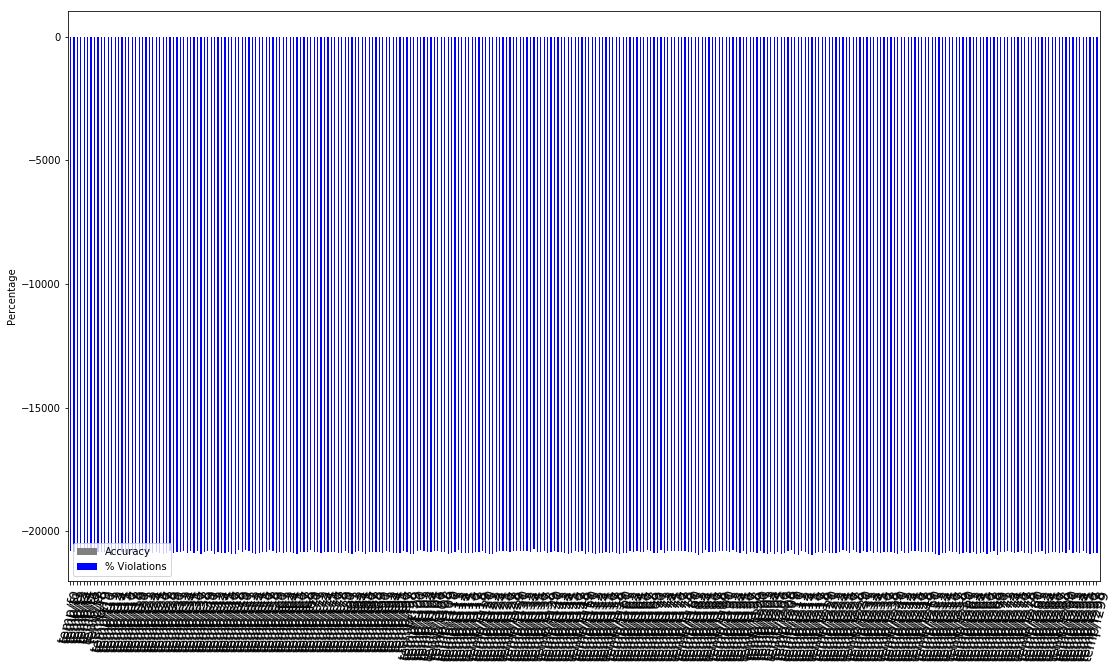

temp/f0
Area under surface (rectangular approx) =  16.715719834521195
Violations =  0.0
Average_violations =  -20789.39718147789
MSE =  0.3607879692318871
temp/f1
Area under surface (rectangular approx) =  17.492330436785426
Violations =  0.0
Average_violations =  -20823.409945835043
MSE =  0.3583079598592036
temp/f2
Area under surface (rectangular approx) =  17.568158577096316
Violations =  0.0
Average_violations =  -20853.02369393952
MSE =  0.35679508516696673
temp/f3
Area under surface (rectangular approx) =  18.237619536290733
Violations =  0.0
Average_violations =  -20827.26994940346
MSE =  0.3623526560406787
temp/f4
Area under surface (rectangular approx) =  18.419080910982235
Violations =  0.0
Average_violations =  -20898.541592484242
MSE =  0.36170260403902743
temp/f5
Area under surface (rectangular approx) =  19.06392887388705
Violations =  0.0
Average_violations =  -20886.881840329002
MSE =  0.3644926397068962
temp/f6
Area under surface (rectangular approx) =  18.419773316101

Area under surface (rectangular approx) =  18.708582650572836
Violations =  0.0
Average_violations =  -20923.09639124599
MSE =  0.3587152830801575
temp/f253
Area under surface (rectangular approx) =  20.803903389939414
Violations =  0.0
Average_violations =  -20957.858335515328
MSE =  0.36904536780875197
temp/f254
Area under surface (rectangular approx) =  20.890296616408527
Violations =  0.0
Average_violations =  -20885.91508961932
MSE =  0.360712035669116
temp/f255
Area under surface (rectangular approx) =  18.480472804978454
Violations =  0.0
Average_violations =  -20865.207409381885
MSE =  0.35938218906052716
temp/f256
Area under surface (rectangular approx) =  17.770366395898478
Violations =  0.0
Average_violations =  -20813.31432368149
MSE =  0.3604103586757128
temp/f257
Area under surface (rectangular approx) =  17.975753164652936
Violations =  0.0
Average_violations =  -20817.316535090435
MSE =  0.3577905186846859
temp/f258
Area under surface (rectangular approx) =  17.17475379

In [6]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
#VIO = np.abs(VIO)
#VIO2 = np.abs(VIO2)


-0.6582792015503192


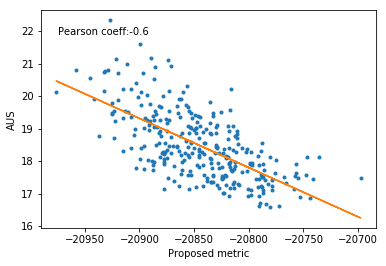

0.4321675582327473


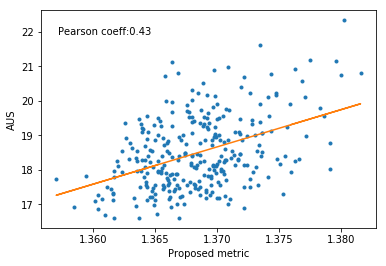

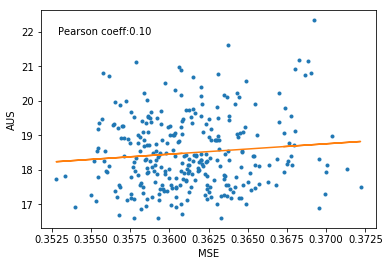

-297.36951528128725 -0.015152412360513344


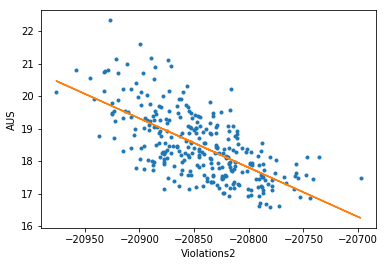

0.3522930701993604 -4.318004031486778e-07


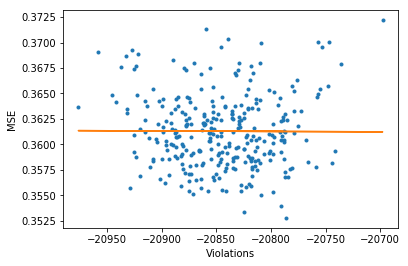

-129.2394771376972 107.95537538424502


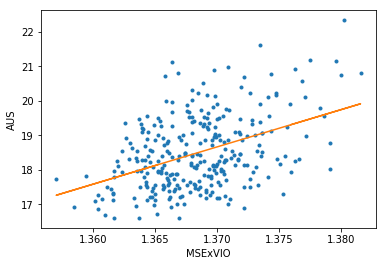

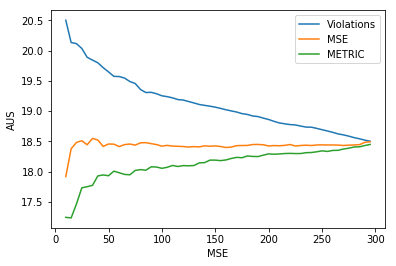

0.4321675582327473

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO2,AUS, 1)
print(b,m)
ax.plot(VIO2,AUS, '.')
plt.plot(VIO2, b + m * np.array(VIO2), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations2")
ax.set_ylabel("AUS")
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
print(b,m)
ax.plot(METRIC,AUS, '.')
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSExVIO")
ax.set_ylabel("AUS")
plt.show()

MSE = np.array(MSE)
METRIC = VIO/np.max(VIO)+ MSE
x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'Violations')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [106]:
def gen_data(mean = 0, var = 1, SIZE = 2000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    g = a + b + c + np.random.normal(mean,var, SIZE)
    d = g + np.random.normal(mean, var, SIZE)
    e = g + np.random.normal(mean, var, SIZE)
    f = g + np.random.normal(mean, var, SIZE)
    
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})
